<a href="https://colab.research.google.com/github/prodramp/DeepWorks/blob/main/DL-SatelliteImagery/Satellite_Imagery_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
from tensorflow.keras.utils import to_categorical 
from matplotlib import pyplot as plt
import random
import glob


2023-11-29 11:10:53.460525: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 11:10:53.506387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 11:10:54.160552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, ConvLSTM2D, Reshape
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K


In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

import tensorflow as tf

# To visualize the model
from keras.utils.vis_utils import plot_model

import keras
from IPython.display import clear_output
%matplotlib inline

Segmentation Models: using `tf.keras` framework.


In [4]:
import tensorflow as tf
device = tf.device("/GPU:0" if tf.test.is_gpu_available() else "/CPU:0")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-11-29 11:10:58.892591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 11:10:58.893970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 11:10:58.959818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [6]:
#import sys
#sys.path.append('/home/luser/UniBw-STELAR/dataset/')


In [7]:
labels = np.load('/home/luser/UniBw-STELAR/dataset/test_saves/arbitrary_10_labels.npy')
labels = labels.reshape(1, 10002, 10002)

In [8]:

filepaths = glob.glob('/home/luser/UniBw-STELAR/dataset/france2/processed_lai_npy/*.npy')

filepaths.sort()

In [9]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)


  # Reshape the output of c5 for ConvLSTM2D

  c5_reshaped = Reshape((1, image_height // 16, image_width // 16, 256))(c5)

  # Add a ConvLSTM2D layer
  convlstm = ConvLSTM2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", return_sequences=True)(c5_reshaped)
  
  convlstm = Reshape((image_height // 16, image_width // 16, 256))(convlstm)  # Reshape back to 4D


  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model


# To get two plots
class PlotLossEx(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.jaccard_coef = []
        self.val_jaccard_coef = []
        self.fig = plt.figure()
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))

        self.jaccard_coef.append(logs.get("jaccard_coef"))
        self.val_jaccard_coef.append(logs.get("val_jaccard_coef"))

        self.i += 1

        plt.figure(figsize=(14, 8))
        f, (graph1, graph2) = plt.subplots(1, 2, sharex=True)

        clear_output(wait=True)
        
        graph1.set_yscale('log')
        graph1.plot(self.x, self.losses, label="loss")
        graph1.plot(self.x, self.val_losses, label="val_loss")
        graph1.legend()

        graph2.set_yscale('log')
        graph2.plot(self.x, self.jaccard_coef, label="jaccard_coef")
        graph2.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")

        graph2.legend()
        plt.show();
    
plot_loss = PlotLossEx()

In [10]:
k = 5
temporal_list = [k+0, k+1, k+2, k+3, k+4, k+5, k+6, k+7, k+8, k+9]

In [11]:
filepaths[temporal_list[3]]

'/home/luser/UniBw-STELAR/dataset/france2/processed_lai_npy/Q_LAI_2020_measure_08.npy'

In [12]:
image_dataset = np.array([])
for i in temporal_list:
    img = np.load(filepaths[i])
    image_dataset = np.append(image_dataset, img)
image_dataset = image_dataset.reshape(-1, 10002, 10002)

In [13]:
total_classes = 10

patch_len_x = 256
patch_len_y = 256

ind_i = np.random.randint(0, int(10002/patch_len_x))
ind_j = np.random.randint(0, int(10002/patch_len_y))

ind_i_test = np.random.randint(0, int(10002/patch_len_x))
ind_j_test = np.random.randint(0, int(10002/patch_len_y))

X_train = image_dataset[:, patch_len_x*ind_i:patch_len_x*(ind_i+1), patch_len_y*ind_j:patch_len_y*(ind_j+1)]
X_train = X_train.reshape(-1, patch_len_x, patch_len_y, 1)

X_test = image_dataset[:, patch_len_x*ind_i_test:patch_len_x*(ind_i_test+1), patch_len_y*ind_j_test:patch_len_y*(ind_j_test+1)]
X_test = X_test.reshape(-1, patch_len_x, patch_len_y, 1)[:4]

y_train = labels[:, patch_len_x*ind_i:patch_len_x*(ind_i+1), patch_len_y*ind_j:patch_len_y*(ind_j+1)]
y_train = np.tile(y_train, (len(temporal_list), 1, 1))
y_train = y_train.reshape(-1, patch_len_x, patch_len_y, 1)
y_train = to_categorical(y_train, num_classes=total_classes)

y_test = labels[:, patch_len_x*ind_i_test:patch_len_x*(ind_i_test+1), patch_len_y*ind_j_test:patch_len_y*(ind_j_test+1)]
y_test = np.tile(y_test, (len(temporal_list), 1, 1))
y_test = y_test.reshape(-1, patch_len_x, patch_len_y, 1)
y_test = to_categorical(y_test, num_classes=total_classes)[:4]


image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

metrics = ["accuracy", jaccard_coef]

weights = [1/total_classes for i in range(total_classes)]



In [14]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

model = get_deep_learning_model()

dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

tf.keras.backend.clear_session()
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)
model.summary()

# uncomment for visualizing
#plot_model(model, to_file='satellite_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [15]:
X_train.shape, y_train.shape

((10, 256, 256, 1), (10, 256, 256, 10))

<Figure size 1400x800 with 0 Axes>

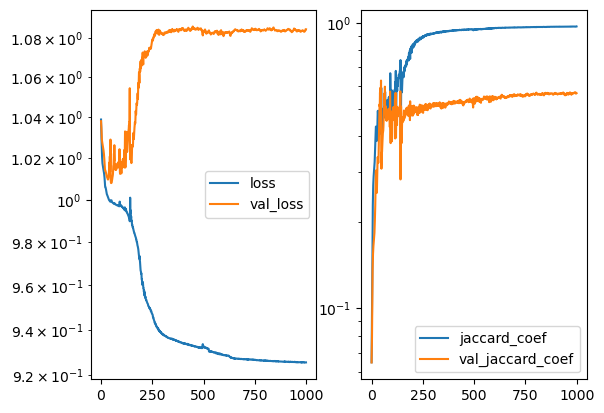

1/1 [==============================] - 1s 504ms/step - loss: 0.9255 - accuracy: 0.9865 - jaccard_coef: 0.9690 - val_loss: 1.0843 - val_accuracy: 0.7279 - val_jaccard_coef: 0.5663


In [16]:
# Training the model
#Two graph
model_history = model.fit(X_train, y_train,
                          batch_size=10,
                          verbose=1,
                          epochs=1000,
                          validation_data=(X_test, y_test),
                          callbacks=[plot_loss],
                          shuffle=False)

In [17]:
'''
#One graph
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=10,
                          validation_data=(X_test, y_test),
                          callbacks=[plot_loss],
                          shuffle=False)'''

'\n#One graph\nmodel_history = model.fit(X_train, y_train,\n                          batch_size=16,\n                          verbose=1,\n                          epochs=10,\n                          validation_data=(X_test, y_test),\n                          callbacks=[plot_loss],\n                          shuffle=False)'

In [18]:
history_a = model_history


In [19]:
history_a.history

{'loss': [1.038787841796875,
  1.033698320388794,
  1.0303287506103516,
  1.0265834331512451,
  1.0226141214370728,
  1.0206468105316162,
  1.0185917615890503,
  1.0173929929733276,
  1.0166290998458862,
  1.0160527229309082,
  1.0154306888580322,
  1.0148735046386719,
  1.014338493347168,
  1.0137526988983154,
  1.0131325721740723,
  1.0123964548110962,
  1.0115437507629395,
  1.0104979276657104,
  1.0091029405593872,
  1.0075229406356812,
  1.006211280822754,
  1.0058701038360596,
  1.005855917930603,
  1.0054532289505005,
  1.0049351453781128,
  1.0043315887451172,
  1.0038377046585083,
  1.0032482147216797,
  1.0027180910110474,
  1.002339243888855,
  1.0021919012069702,
  1.001909613609314,
  1.0015538930892944,
  1.0012531280517578,
  1.0010693073272705,
  1.0008699893951416,
  1.0005947351455688,
  1.0002861022949219,
  1.0000883340835571,
  0.9997953176498413,
  0.9996922612190247,
  0.9995323419570923,
  0.9993795156478882,
  0.9992830157279968,
  0.9991401433944702,
  0.99913

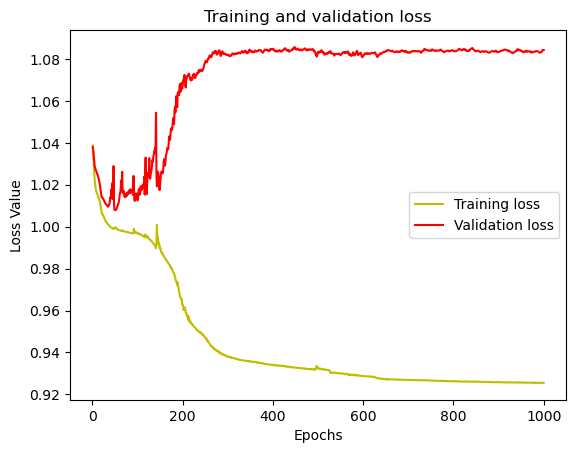

In [20]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')   
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()


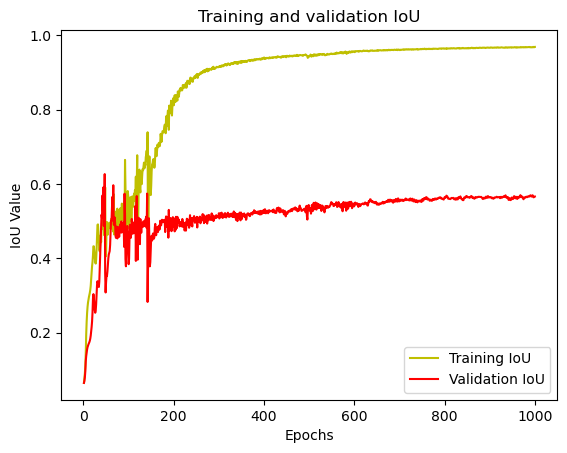

In [21]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']
epochs = range(1, len(jaccard_coef) + 1)

plt.plot(epochs, jaccard_coef, 'y', label='Training IoU')
plt.plot(epochs, val_jaccard_coef, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU Value')
plt.legend()
plt.show()


In [22]:
model_history.params

{'verbose': 1, 'epochs': 1000, 'steps': 1}

In [23]:
# Saving the model

model.save('./saved_model/sat_stelar_image_segmentation_baseline.h5')

In [24]:
# Loading the model


import keras.backend as K
import segmentation_models as sm

def dice_loss_plus_1focal_loss(y_true, y_pred):
    # Compute dice loss using the DiceLoss class from segmentation_models
    dice_loss = sm.losses.DiceLoss(class_weights=weights)(y_true, y_pred)

    # Compute focal loss using the CategoricalFocalLoss class from segmentation_models
    focal_loss = sm.losses.CategoricalFocalLoss()(y_true, y_pred)

    # Combine the dice loss and focal loss
    total_loss = dice_loss + (1 * focal_loss)

    return total_loss

In [25]:
import keras
from keras import models

# Register the custom loss function
keras.losses.dice_loss_plus_1focal_loss = dice_loss_plus_1focal_loss
keras.metrics.jaccard_coef = jaccard_coef
# Load the saved model
#model = models.load_model('./saved_model/sat_stelar_image_segmentation.h5')
model = models.load_model('./saved_model/sat_stelar_image_segmentation_baseline.h5') # 10 classes 7000 sample size Unet convergence


# Comparing prediction results

##### using test images, using mask images and predicted result images

1/1 [==============================] - 1s 553ms/step


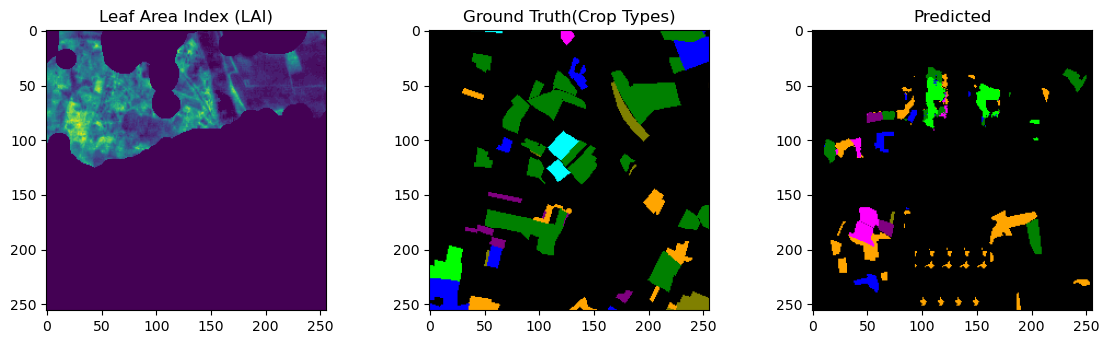

In [26]:
#X_test = X_train
#y_test = y_train

y_test_argmax = np.argmax(y_test, axis=3)
test_image_number = random.randint(0, len(X_test)-1)

test_image = X_test[test_image_number]
groud_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, axis=0)

prediction = (model.predict(test_image_input))
predicted_image = np.argmax(prediction, axis=-1)
predicted_image = predicted_image[0,:,:]





groud_truth_image = groud_truth_image
predicted_image = predicted_image

color_map = {
    0: [0, 0, 0],      # Black
    1: [0, 255, 0],      # Green
    2: [0, 0, 255],      # Blue
    3: [255, 255, 0],    # Yellow
    4: [255, 165, 0],    # Orange
    5: [255, 0, 255],    # Magenta
    6: [0, 255, 255],    # Cyan
    7: [128, 0, 128],    # Violet
    8: [128, 128, 0],    # Olive
    9: [0, 128, 0],      # Dark Green
    10: [128, 0, 0],     # Maroon
    11: [0, 0, 128],     # Navy
    12: [128, 128, 128], # Gray
    13: [0, 128, 128],   # Teal
    14: [255, 0, 0],      # Red
    15: [255, 255, 255], # White
    16: [192, 192, 192], # Silver
    17: [255, 0, 0],     # Red (Duplicate)
    18: [0, 255, 0],     # Green (Duplicate)
    19: [0, 0, 255],     # Blue (Duplicate)
    20: [255, 255, 0],   # Yellow (Duplicate)
    21: [255, 165, 0],   # Orange (Duplicate)
    22: [255, 0, 255],   # Magenta (Duplicate)
    23: [0, 255, 255],   # Cyan (Duplicate)
    24: [128, 0, 128],   # Violet (Duplicate)
    25: [128, 128, 0],   # Olive (Duplicate)
    26: [0, 128, 0],     # Dark Green (Duplicate)
    27: [128, 0, 0],     # Maroon (Duplicate)
    28: [0, 0, 128],     # Navy (Duplicate)
    29: [128, 128, 128], # Gray (Duplicate)
    30: [0, 128, 128],   # Teal (Duplicate)
    31: [0, 0, 0],       # Black (Duplicate)
    32: [255, 255, 255], # White (Duplicate)
    33: [192, 192, 192], # Silver (Duplicate)
    34: [255, 0, 0],     # Red (Duplicate)
    35: [0, 255, 0],     # Green (Duplicate)
    36: [0, 0, 255],     # Blue (Duplicate)
    37: [255, 255, 0],   # Yellow (Duplicate)
    38: [255, 165, 0],   # Orange (Duplicate)
    39: [255, 0, 255],   # Magenta (Duplicate)
    40: [0, 128, 255]    # Sky Blue (New Color)
}


# Create color plot
groud_truth_color_image = np.zeros(groud_truth_image.shape + (3,), dtype=np.uint8)
predicted_color_image = np.zeros(predicted_image.shape + (3,), dtype=np.uint8)
for i in range(groud_truth_image.shape[0]):
    for j in range(groud_truth_image.shape[1]):
        segment_id_gt = groud_truth_image[i, j]
        segment_id_pd = predicted_image[i, j]
        groud_truth_color_image[i, j] = color_map[segment_id_gt]
        predicted_color_image[i, j] = color_map[segment_id_pd]





# Put all the 3 images together and display
plt.figure(figsize=(14, 8))
plt.subplot(231)
plt.title('Leaf Area Index (LAI)')
test_image[test_image<0] = 0
plt.imshow(test_image)
plt.subplot(232)
plt.title('Ground Truth(Crop Types)')
#plt.imshow(groud_truth_image)
plt.imshow(groud_truth_color_image)
plt.subplot(233)
plt.title('Predicted')
#plt.imshow(predicted_image)
plt.imshow(predicted_color_image)

In [27]:
#plots

# Class Imbalance Analysis

In [28]:
# Evaluation

X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

NameError: name 'train_test_split' is not defined

In [ ]:
y_test.shape, y_test.shape

In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)


In [ ]:
# get unique values in the y_test_argmax set and their frequency and plot the histogram
unique, counts = np.unique(y_test_argmax, return_counts=True)
plt.bar(unique, counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()




In [ ]:
unique, counts = np.unique(y_test_argmax, return_counts=True)
dict(zip(unique, counts))


In [ ]:
unique, counts

# Segmentation Quality Measurements

## Intersection over Union (IoU)

In [ ]:
from sklearn.metrics import jaccard_score, f1_score, accuracy_score

In [ ]:
test_image = X_test[test_image_number]
test_image.shape

In [ ]:
X_test.shape

In [ ]:
len(X_test)

In [ ]:
no_classes = 10
crop = 0

all_class_iou = []
for crop in range(no_classes):
    all_iou = []
    for test_image_number in range(len(X_test)-1040):

        test_image = X_test[test_image_number]
        y_test_argmax = np.argmax(y_test, axis=3)
        groud_truth_image = y_test_argmax[test_image_number]
        test_image_input = np.expand_dims(test_image, axis=0)
        prediction = (model.predict(test_image_input))
        predicted_image = np.argmax(prediction, axis=-1)
        predicted_image = predicted_image[0,:,:]
        img_true=np.array(groud_truth_image).ravel()
        img_pred=np.array(predicted_image).ravel()

        for i in range(no_classes):
            if(i==crop):
                img_true[img_true==i]=100
                img_pred[img_pred==i]=100
            else:
                img_true[img_true==i]=0
                img_pred[img_pred==i]=0


        iou = jaccard_score(img_true, img_pred, average='macro')

        print(iou)

        all_iou.append(iou)
    all_class_iou.append(all_iou)

In [ ]:
len(all_class_iou[0])

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(all_class_iou)
ax.set_xticklabels(['Crop type 1', 'Crop type 2', 'Crop type 3', 'Crop type 4', 'Crop type 5', 'Crop type 6', 'Crop type 7', 'Crop type 8', 'Crop type 9', 'Crop type 10'], rotation=45)

ax.set_ylabel('Intersection over Union (IoU)')

ax.set_title('Class-wise IoU')

plt.show()


In [ ]:
#f1_sc = f1_score(img_true.flatten(), img_true.flatten(), zero_division=1)
f1_sc = f1_score(img_true.flatten(), img_true.flatten(), labels=[0, 100], pos_label=100, average='binary', zero_division=1)


# F1 Score

In [ ]:
#dice = f1_score(img_true.flatten(), img_pred.flatten(), zero_division=1)
#dice


no_classes = 10
#crop = 0

all_class_f1_sc = []
for crop in range(no_classes):
    all_f1_sc = []
    for test_image_number in range(len(X_test)-1040):

        test_image = X_test[test_image_number]
        y_test_argmax = np.argmax(y_test, axis=3)
        groud_truth_image = y_test_argmax[test_image_number]
        test_image_input = np.expand_dims(test_image, axis=0)
        prediction = (model.predict(test_image_input))
        predicted_image = np.argmax(prediction, axis=-1)
        predicted_image = predicted_image[0,:,:]
        img_true=np.array(groud_truth_image).ravel()
        img_pred=np.array(predicted_image).ravel()

        for i in range(no_classes):
            if(i==crop):
                img_true[img_true==i]=100
                img_pred[img_pred==i]=100
            else:
                img_true[img_true==i]=0
                img_pred[img_pred==i]=0

        f1_sc = f1_score(img_true.flatten(), img_pred.flatten(), labels=[0, 100], pos_label=100, average='binary', zero_division=1)
        print(f1_sc)
        all_f1_sc.append(f1_sc)
    all_class_f1_sc.append(all_f1_sc)

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(all_class_f1_sc)
ax.set_xticklabels(['Crop type 1', 'Crop type 2', 'Crop type 3', 'Crop type 4', 'Crop type 5', 'Crop type 6', 'Crop type 7', 'Crop type 8', 'Crop type 9', 'Crop type 10'], rotation=45)

ax.set_ylabel('F1 score')

ax.set_title('Class-wise F1-Score')

plt.show()


# Accuracy

